In [ ]:
#pip install -r requirements.txt

In [1]:
import threading, time, uvicorn

def run():
    uvicorn.run("main:app", host="127.0.0.1", port=8000, reload=False, log_level="info")

t = threading.Thread(target=run, daemon=True)
t.start()
time.sleep(2)  # espera a que arranque
print("Servidor local en http://127.0.0.1:8000")


INFO:     Started server process [592]
INFO:     Waiting for application startup.


INFO:     Application startup complete.
ERROR:    [Errno 10048] error while attempting to bind on address ('127.0.0.1', 8000): solo se permite un uso de cada dirección de socket (protocolo/dirección de red/puerto)
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


[startup] Modelo cargado OK
Servidor local en http://127.0.0.1:8000


In [8]:
import requests, base64
from PIL import Image
from io import BytesIO

URL_API = "http://127.0.0.1:8000/predict"  # <— local

def predict_any(image_url: str | None = None, image_path: str | None = None, timeout: int = 20):
    if bool(image_url) == bool(image_path):
        raise ValueError("Proporciona exactamente uno: image_url o image_path.")

    # Armar payload
    if image_url:
        payload = {"image_url": image_url}
    else:
        with open(image_path, "rb") as f:
            img_b64 = base64.b64encode(f.read()).decode("utf-8")
        payload = {"image_base64": img_b64}

    # Llamada
    try:
        r = requests.post(URL_API, json=payload, timeout=timeout)
    except requests.RequestException as e:
        print("Error de red:", e)
        return

    print("HTTP", r.status_code)

    # Intentar parsear JSON
    try:
        data = r.json()
    except ValueError:
        print("Respuesta no JSON:", r.text[:400])
        return

    # Manejo universal
    if r.ok:
        print("Label:", data.get("label"))
        print("Decision:", data.get("decision"))
        print("Score:", data.get("score"))
        print("Probabilidades:", data.get("probs"))

        thumb_b64 = data.get("image_thumb_base64")
        if thumb_b64:
            try:
                img = Image.open(BytesIO(base64.b64decode(thumb_b64)))
                display(img)
            except Exception as e:
                print("No se pudo mostrar la miniatura:", e)
    else:
        print("Error:", data.get("detail", data))


HTTP 200
Label: fresh
Decision: fresh
Score: 0.995426
Probabilidades: {'fresh': 0.995426, 'infected': 0.004574}


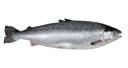

In [9]:
predict_any(image_url="https://www.gastronomiavasca.net/uploads/image/file/3268/salmon.jpg")

HTTP 200
Label: infected
Decision: infected
Score: 0.786383
Probabilidades: {'fresh': 0.213617, 'infected': 0.786383}


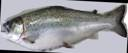

In [10]:
 predict_any(image_path=r"C:\Users\galla\OneDrive\Escritorio\UDD\MAGISTER\4to trimestre\Vision computacional\Tareas\Tarea4\outPath\val\infected_143.png")

In [11]:
predict_any(image_url="C:/Users/galla/OneDrive/Escritorio/ER Rendimiento por alumno, bases Web.pdf")

HTTP 422
Error: [{'type': 'url_scheme', 'loc': ['body', 'image_url'], 'msg': "URL scheme should be 'http' or 'https'", 'input': 'C:/Users/galla/OneDrive/Escritorio/ER Rendimiento por alumno, bases Web.pdf', 'ctx': {'expected_schemes': "'http' or 'https'"}}]


In [12]:
predict_any(image_url="https://datosabiertos.mineduc.cl/wp-content/uploads/2025/04/Rendimiento_2024.rar")

Error de red: HTTPConnectionPool(host='127.0.0.1', port=8000): Read timed out. (read timeout=20)
